This notebook provides a visualisation of the raw data for the monoisotope, and shows the curve that was fitted to find the RT apex.
It relies on the following files from BAM:
- scp -i ~/Documents/AWS\ keys/dwm-protlab.pem ubuntu@3.211.113.236:~/experiments/dwm-test/target-decoy-models/experiment-metrics-for-library-sequences.pkl ~/Downloads/experiments/dwm-test/target-decoy-models/

Note that sequences_metrics_df contains unclassified features - it may contain features classified as decoys from particular runs. In this notebook we rely on the 'analyse the isotope intensity adjustment by peptide' notebook to identify sequences of interest in particular runs.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import json
import numpy as np

In [2]:
EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
TEMP_DIR = '/home/ubuntu'

In [3]:
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

In [4]:
EXTRACTED_FEATURES_DIR = "{}/extracted-features".format(EXPERIMENT_DIR)
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features.sqlite".format(EXTRACTED_FEATURES_DIR)


In [5]:
run_name = '190719_Hela_Ecoli_1to3_02'
file_idx = file_idx_for_run(run_name)

In [6]:
selected_sequence = 'DAMVPMGGLLCMK'
selected_sequence_charge = 2

In [7]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
selected_sequence_s = pd.read_sql_query('select * from features where file_idx=={} and sequence==\'{}\' and charge=={}'.format(file_idx,selected_sequence,selected_sequence_charge), db_conn).iloc[0]
db_conn.close()

In [8]:
mono_raw_points_df = pd.DataFrame(json.loads(selected_sequence_s.mono_raw_points_l), columns=['retention_time_secs','intensity'])
mono_filtered_points_df = pd.DataFrame(json.loads(selected_sequence_s.mono_filtered_points_l))
isotope_1_filtered_points_df = pd.DataFrame(json.loads(selected_sequence_s.isotope_1_filtered_points_l))
isotope_2_filtered_points_df = pd.DataFrame(json.loads(selected_sequence_s.isotope_2_filtered_points_l))

In [9]:
mono_rt_lower,mono_rt_upper = json.loads(selected_sequence_s.mono_rt_bounds)
mono_isolated_peak_df = mono_filtered_points_df[(mono_filtered_points_df.x >= mono_rt_lower) & (mono_filtered_points_df.x <= mono_rt_upper)]
mono_rt_apex_derived = selected_sequence_s.rt_apex
# mono_rt_apex_estimated = selected_peak_df.target_coords['rt_apex']

In [10]:
isotope_1_rt_lower,isotope_1_rt_upper = json.loads(selected_sequence_s.isotope_1_rt_bounds)
isotope_1_isolated_peak_df = isotope_1_filtered_points_df[(isotope_1_filtered_points_df.x >= isotope_1_rt_lower) & (isotope_1_filtered_points_df.x <= isotope_1_rt_upper)]

In [11]:
isotope_2_rt_lower,isotope_2_rt_upper = json.loads(selected_sequence_s.isotope_2_rt_bounds)
isotope_2_isolated_peak_df = isotope_2_filtered_points_df[(isotope_2_filtered_points_df.x >= isotope_2_rt_lower) & (isotope_2_filtered_points_df.x <= isotope_2_rt_upper)]

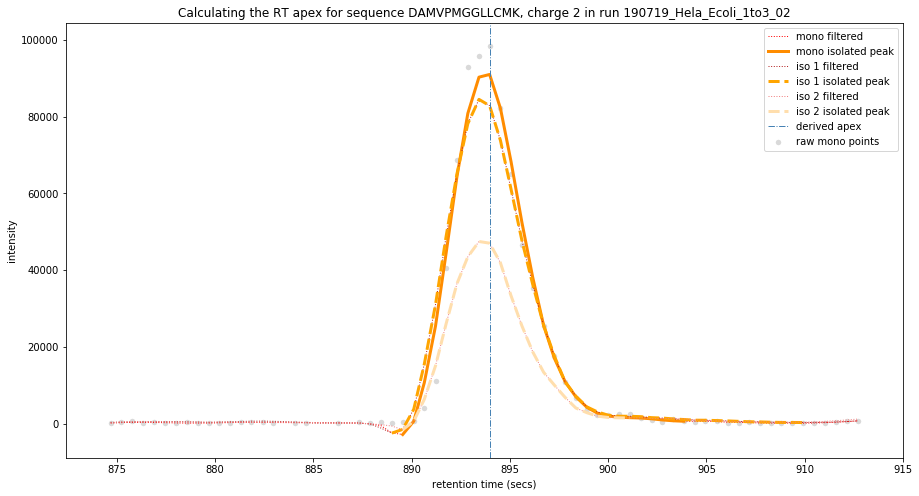

In [12]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Calculating the RT apex for sequence {}, charge {} in run {}'.format(selected_sequence, selected_sequence_charge, run_name)
plt.title(title)

ax.scatter(mono_raw_points_df.retention_time_secs, mono_raw_points_df.intensity, marker='o', color='silver', lw=0, s=30, alpha=0.6, label='raw mono points')

# isotope 0
ax.plot(mono_filtered_points_df.x, mono_filtered_points_df.filtered_intensity, marker='', color='red', linestyle=':', linewidth=1, ms=5, label='mono filtered')
ax.plot(mono_isolated_peak_df.x, mono_isolated_peak_df.filtered_intensity, marker='', color='darkorange', linestyle='-', linewidth=3, ms=5, label='mono isolated peak')

# isotope 1
ax.plot(isotope_1_filtered_points_df.x, isotope_1_filtered_points_df.filtered_intensity, marker='', color='firebrick', linestyle=':', linewidth=1, ms=5, label='iso 1 filtered')
ax.plot(isotope_1_isolated_peak_df.x, isotope_1_isolated_peak_df.filtered_intensity, marker='', color='orange', linestyle='--', linewidth=3, ms=5, label='iso 1 isolated peak')

# isotope 2
ax.plot(isotope_2_filtered_points_df.x, isotope_2_filtered_points_df.filtered_intensity, marker='', color='lightcoral', linestyle=':', linewidth=1, ms=5, label='iso 2 filtered')
ax.plot(isotope_2_isolated_peak_df.x, isotope_2_isolated_peak_df.filtered_intensity, marker='', color='navajowhite', linestyle='--', linewidth=3, ms=5, label='iso 2 isolated peak')

ax.axvline(mono_rt_apex_derived, color='steelblue', lw=1.0, ls='-.', label='derived apex')
# ax.axvline(mono_rt_apex_estimated, color='limegreen', lw=1.0, ls='-.', label='estimated apex')

plt.legend(loc='best')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')

plt.show()

#### plot the monoisotopic peaks for all the runs for thie selected sequence

In [13]:
selected_batch = '1to1'

In [14]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
selected_sequence_df = pd.read_sql_query('select * from features where sequence==\'{}\' and charge=={} and batch==\'{}\' order by run_name'.format(selected_sequence,selected_sequence_charge,selected_batch), db_conn)
db_conn.close()

In [15]:
selected_sequence_df['log_intensity'] = np.log2(selected_sequence_df.intensity)

In [16]:
selected_sequence_df

,sequence,charge,file_idx,peak_idx,attributes,delta_mz_ppm,delta_rt,delta_scan,fwhm_rt_0,fwhm_scan_0,...,mono_rt_bounds,monoisotopic_mass,monoisotopic_mz_centroid,rt_apex,scan_apex,run_name,batch,human,number_of_runs_identified,log_intensity
0,DAMVPMGGLLCMK,2,11,0,"{""intensity"": 11492, ""inferred"": 1, ""isotope_i...",-0.074964,0.000392,-0.006920,3.439850,13.7375,...,"[897.2165269241115, 905.9804751878692]",1421.655057,711.834804,901.601846,581.0,190719_Hela_Ecoli_1to1_01,1to1,0,20,13.488342
1,DAMVPMGGLLCMK,2,16,0,"{""intensity"": 3859, ""inferred"": 0, ""isotope_id...",0.637369,-0.000184,0.006178,3.597409,23.9425,...,"[896.0244596737991, 905.1898335991135]",1421.654997,711.834775,900.366499,579.0,190719_Hela_Ecoli_1to1_02,1to1,0,20,11.914011
2,DAMVPMGGLLCMK,2,6,0,"{""intensity"": 307, ""inferred"": 1, ""isotope_idx...",0.655193,-0.000081,-0.008535,3.604583,14.9150,...,"[896.7456636035802, 905.9293148877487]",1421.655036,711.834794,901.073232,579.0,190719_Hela_Ecoli_1to1_03,1to1,0,20,8.262095
3,DAMVPMGGLLCMK,2,15,0,"{""intensity"": 26218, ""inferred"": 1, ""isotope_i...",0.582321,0.000711,-0.000176,3.362144,13.3450,...,"[896.1558738487741, 904.7218450059302]",1421.655063,711.834808,900.995407,582.0,190719_Hela_Ecoli_1to1_04,1to1,0,20,14.678270
4,DAMVPMGGLLCMK,2,18,0,"{""intensity"": 10134, ""inferred"": 0, ""isotope_i...",0.481883,-0.000268,0.026998,3.813078,3.5325,...,"[895.4344569976043, 905.1493056251678]",1421.655050,711.834801,900.296668,581.0,190719_Hela_Ecoli_1to1_05,1to1,0,20,13.306916
5,DAMVPMGGLLCMK,2,19,0,"{""intensity"": 5439, ""inferred"": 1, ""isotope_id...",0.530091,0.000256,-0.005695,3.577785,3.1400,...,"[892.0787433738833, 901.1941185601698]",1421.655047,711.834800,896.389277,576.0,190719_Hela_Ecoli_1to1_06,1to1,0,20,12.409126
6,DAMVPMGGLLCMK,2,1,0,"{""intensity"": 9740, ""inferred"": 1, ""isotope_id...",0.729647,0.000394,-0.012768,3.781697,12.1675,...,"[892.9485585006279, 902.5834547167133]",1421.655030,711.834791,897.807083,572.0,190719_Hela_Ecoli_1to1_07,1to1,0,20,13.249706
7,DAMVPMGGLLCMK,2,10,0,"{""intensity"": 17647, ""inferred"": 0, ""isotope_i...",0.459307,0.000292,-0.014459,3.573608,15.3075,...,"[893.1144640707824, 902.2191972343047]",1421.655085,711.834819,897.427706,570.0,190719_Hela_Ecoli_1to1_08,1to1,0,20,14.107135
8,DAMVPMGGLLCMK,2,2,0,"{""intensity"": 15583, ""inferred"": 0, ""isotope_i...",0.409465,0.000828,0.022597,3.376430,5.4950,...,"[893.3523603654594, 901.954730524864]",1421.655011,711.834782,897.637817,573.0,190719_Hela_Ecoli_1to1_09,1to1,0,20,13.927685
9,DAMVPMGGLLCMK,2,8,0,"{""intensity"": 17349, ""inferred"": 1, ""isotope_i...",0.827513,0.000435,0.030066,3.586713,13.7375,...,"[893.649833200299, 902.7879551604018]",1421.655092,711.834822,897.977870,576.0,190719_Hela_Ecoli_1to1_10,1to1,0,20,14.082565


#### calculate the maximum intensity so we can set all the plot axes to be the same range

In [17]:
selected_sequence_df['max_mono_raw_intensity'] = selected_sequence_df.apply(lambda row: np.max([rt_int[1] for rt_int in json.loads(row.mono_raw_points_l)]), axis=1)
selected_sequence_df['max_iso_1_filtered_intensity'] = selected_sequence_df.apply(lambda row: np.max([d['filtered_intensity'] for d in json.loads(row.isotope_1_filtered_points_l)]), axis=1)
selected_sequence_df['max_iso_2_filtered_intensity'] = selected_sequence_df.apply(lambda row: np.max([d['filtered_intensity'] for d in json.loads(row.isotope_2_filtered_points_l)]), axis=1)


In [18]:
sequence_intensity_max = np.max([selected_sequence_df.max_mono_raw_intensity.max(), selected_sequence_df.max_iso_1_filtered_intensity.max(), selected_sequence_df.max_iso_2_filtered_intensity.max()])


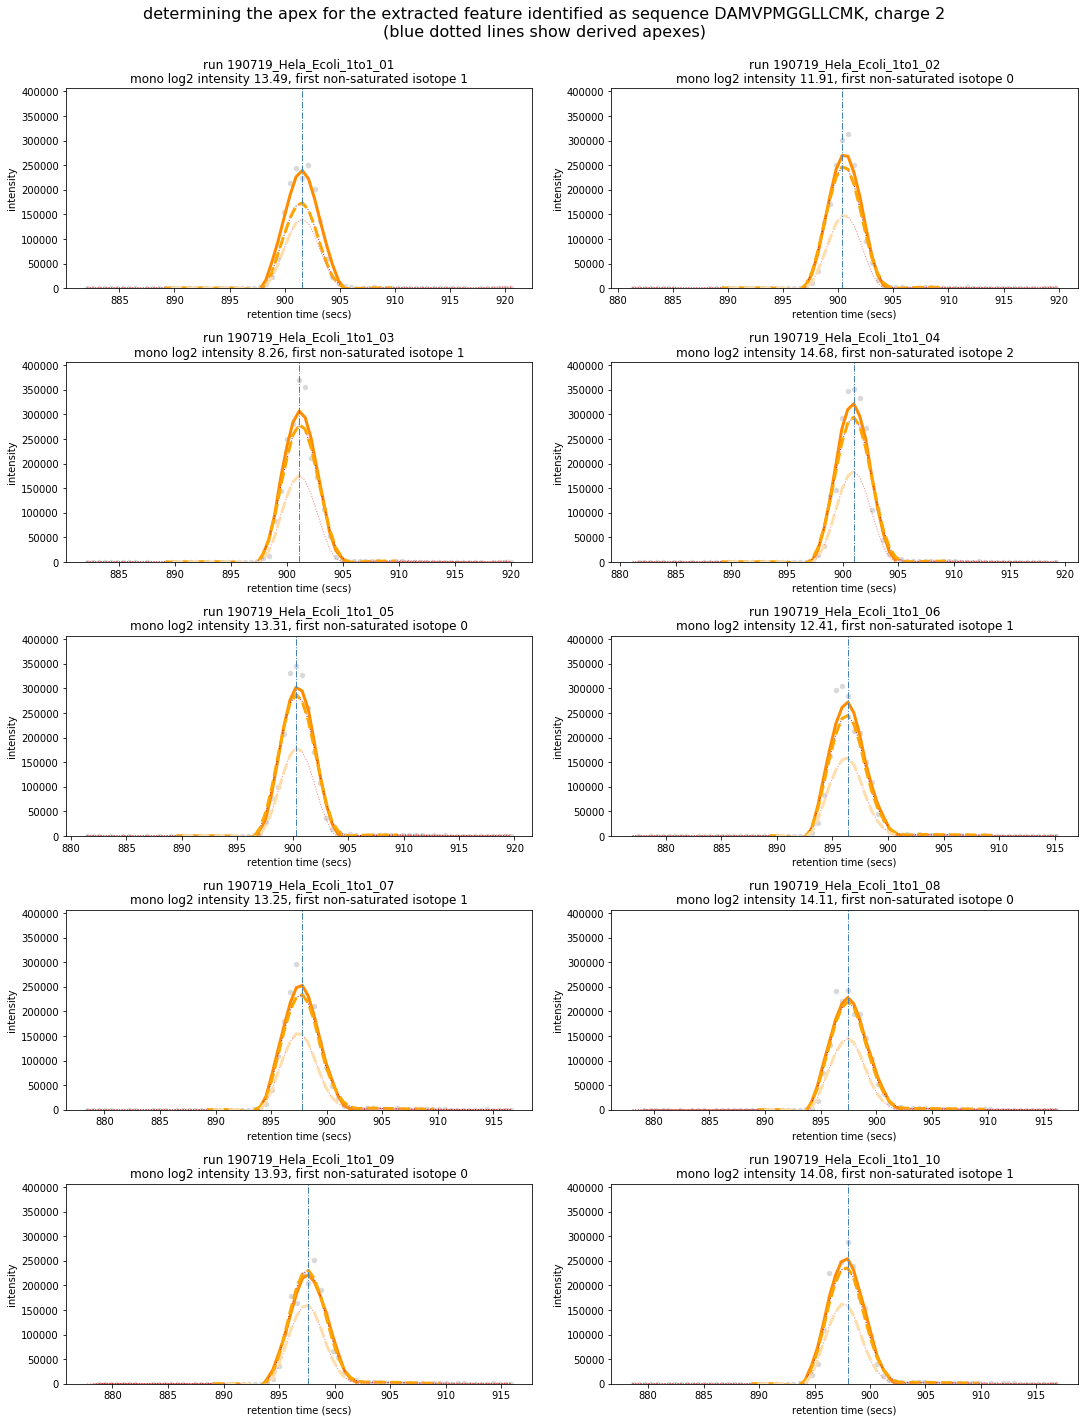

In [19]:
f, axarr = plt.subplots(nrows=5, ncols=2, constrained_layout=True)

f.set_figheight(20)
f.set_figwidth(15)
f.suptitle('determining the apex for the extracted feature identified as sequence {}, charge {}\n(blue dotted lines show derived apexes)\n\n'.format(selected_sequence, selected_sequence_charge), fontsize=16)

for row_idx,row in enumerate(selected_sequence_df.itertuples()):
    r = int(row_idx / 2)
    c = row_idx % 2
    
    ax = axarr[r,c]  # row, column
    ax.set_title('run {}\nmono log2 intensity {}, first non-saturated isotope {}'.format(row.run_name, round(row.log_intensity,2), int(row.isotope_idx_not_in_saturation)))

    mono_raw_points_df = pd.DataFrame(json.loads(row.mono_raw_points_l), columns=['retention_time_secs','intensity'])
    mono_filtered_points_df = pd.DataFrame(json.loads(row.mono_filtered_points_l))
    isotope_1_filtered_points_df = pd.DataFrame(json.loads(row.isotope_1_filtered_points_l))
    isotope_2_filtered_points_df = pd.DataFrame(json.loads(row.isotope_2_filtered_points_l))    

    mono_rt_lower,mono_rt_upper = json.loads(row.mono_rt_bounds)
    mono_isolated_peak_df = mono_filtered_points_df[(mono_filtered_points_df.x >= mono_rt_lower) & (mono_filtered_points_df.x <= mono_rt_upper)]
    mono_rt_apex_derived = row.rt_apex
    # mono_rt_apex_estimated = selected_peak_df.target_coords['rt_apex']    
    
    isotope_1_rt_lower,isotope_1_rt_upper = json.loads(selected_sequence_s.isotope_1_rt_bounds)
    isotope_1_isolated_peak_df = isotope_1_filtered_points_df[(isotope_1_filtered_points_df.x >= isotope_1_rt_lower) & (isotope_1_filtered_points_df.x <= isotope_1_rt_upper)]
    
    isotope_2_rt_lower,isotope_2_rt_upper = json.loads(selected_sequence_s.isotope_2_rt_bounds)
    isotope_2_isolated_peak_df = isotope_2_filtered_points_df[(isotope_2_filtered_points_df.x >= isotope_2_rt_lower) & (isotope_2_filtered_points_df.x <= isotope_2_rt_upper)]

    ax.scatter(mono_raw_points_df.retention_time_secs, mono_raw_points_df.intensity, marker='o', color='silver', lw=0, s=30, alpha=0.6, label='raw mono points')

    # isotope 0
    ax.plot(mono_filtered_points_df.x, mono_filtered_points_df.filtered_intensity, marker='', color='red', linestyle=':', linewidth=1, ms=5, label='mono filtered')
    ax.plot(mono_isolated_peak_df.x, mono_isolated_peak_df.filtered_intensity, marker='', color='darkorange', linestyle='-', linewidth=3, ms=5, label='mono isolated peak')

    # isotope 1
    ax.plot(isotope_1_filtered_points_df.x, isotope_1_filtered_points_df.filtered_intensity, marker='', color='firebrick', linestyle=':', linewidth=1, ms=5, label='iso 1 filtered')
    ax.plot(isotope_1_isolated_peak_df.x, isotope_1_isolated_peak_df.filtered_intensity, marker='', color='orange', linestyle='--', linewidth=3, ms=5, label='iso 1 isolated peak')

    # isotope 2
    ax.plot(isotope_2_filtered_points_df.x, isotope_2_filtered_points_df.filtered_intensity, marker='', color='lightcoral', linestyle=':', linewidth=1, ms=5, label='iso 2 filtered')
    ax.plot(isotope_2_isolated_peak_df.x, isotope_2_isolated_peak_df.filtered_intensity, marker='', color='navajowhite', linestyle='--', linewidth=3, ms=5, label='iso 2 isolated peak')

    # apexes
    ax.axvline(mono_rt_apex_derived, color='steelblue', lw=1.0, ls='-.', label='derived apex')
    # ax.axvline(mono_rt_apex_estimated, color='limegreen', lw=1.0, ls='-.', label='estimated apex')

    # set up axes
    ax.set_ylim((0,sequence_intensity_max*1.1))
    ax.set_xlabel('retention time (secs)')
    ax.set_ylabel('intensity')

plt.show()

#### look at how the intensity was calculated

In [41]:
monoisotope_intensities_l = json.loads(selected_sequence_s.isotope_intensities_l)[0]

In [43]:
summed_intensity = monoisotope_intensities_l[0]
inferred_intensity = monoisotope_intensities_l[2]
isotope_points_l = monoisotope_intensities_l[4]
isotope_apex_points = monoisotope_intensities_l[5]

In [44]:
isotope_df = pd.DataFrame(isotope_points_l, columns=['mz','scan','frame_id','retention_time_secs','intensity'])

In [45]:
mono_rt_apex_derived = selected_sequence_s.rt_apex
mono_rt_apex_derived

893.9688610431593

In [49]:
isotope_apex_df = pd.DataFrame(isotope_apex_points, columns=['mz','scan','frame_id','retention_time_secs','intensity'])


#### calculate intensity for this monoisotope using the 'apex-max' method

In [77]:
isotope_df['rt_delta'] = np.abs(isotope_df.retention_time_secs - mono_rt_apex_derived)
isotope_df.sort_values(by=['rt_delta','intensity'], ascending=[True,False], inplace=True)
isotope_df.reset_index(drop=True, inplace=True)
summed_intensity = isotope_df.loc[:2].intensity.sum()
summed_intensity

17439.0

In [78]:
isotope_apex_df = isotope_df.loc[:2]

In [79]:
isotope_apex_df

,mz,scan,frame_id,retention_time_secs,intensity,rt_delta
0,711.83476,578.0,8311.0,893.968861,5813.0,0.0
1,711.83476,582.0,8311.0,893.968861,5813.0,0.0
2,711.83476,573.0,8311.0,893.968861,5813.0,0.0


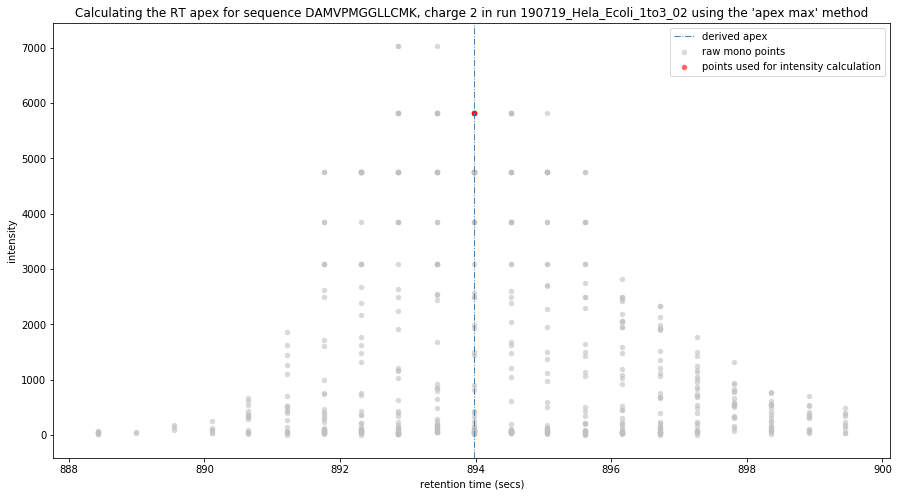

In [80]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Calculating the RT apex for sequence {}, charge {} in run {} using the \'apex max\' method'.format(selected_sequence, selected_sequence_charge, run_name)
plt.title(title)

ax.scatter(isotope_df.retention_time_secs, isotope_df.intensity, marker='o', color='silver', lw=0, s=30, alpha=0.6, label='raw mono points')
ax.scatter(isotope_apex_df.retention_time_secs, isotope_apex_df.intensity, marker='o', color='red', lw=0, s=30, alpha=0.6, label='points used for intensity calculation')

ax.axvline(mono_rt_apex_derived, color='steelblue', lw=1.0, ls='-.', label='derived apex')
# ax.axvline(mono_rt_apex_estimated, color='limegreen', lw=1.0, ls='-.', label='estimated apex')

plt.legend(loc='best')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')

plt.show()

#### calculate intensity for this monoisotope using the 'frame' method

In [81]:
# find the intensity by summing the maximum point in the frame closest to the RT apex, and the frame maximums either side
frame_maximums_l = []
for frame_id,group_df in isotope_df.groupby('frame_id'):
    frame_maximums_l.append(group_df.loc[group_df.intensity.idxmax()])
frame_maximums_df = pd.DataFrame(frame_maximums_l)
frame_maximums_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
frame_maximums_df.reset_index(drop=True, inplace=True)
# find the index closest to the RT apex and the index either side
if (mono_rt_apex_derived is not None):
    frame_maximums_df['rt_delta'] = np.abs(frame_maximums_df.retention_time_secs - mono_rt_apex_derived)
    apex_idx = frame_maximums_df.rt_delta.idxmin()
else:
    apex_idx = frame_maximums_df.intensity.idxmax()
apex_idx_minus_one = max(0, apex_idx-1)
apex_idx_plus_one = min(len(frame_maximums_df)-1, apex_idx+1)
# sum the maximum intensity and the max intensity of the frame either side in RT
summed_intensity = frame_maximums_df.loc[apex_idx_minus_one:apex_idx_plus_one].intensity.sum()
summed_intensity

18655.0

In [82]:
isotope_apex_df = frame_maximums_df.loc[apex_idx_minus_one:apex_idx_plus_one]

In [83]:
isotope_apex_df

,mz,scan,frame_id,retention_time_secs,intensity,rt_delta
9,711.83476,576.0,8306.0,893.426898,7029.0,0.541963
10,711.83476,578.0,8311.0,893.968861,5813.0,0.000000
11,711.83476,579.0,8316.0,894.517743,5813.0,0.548881


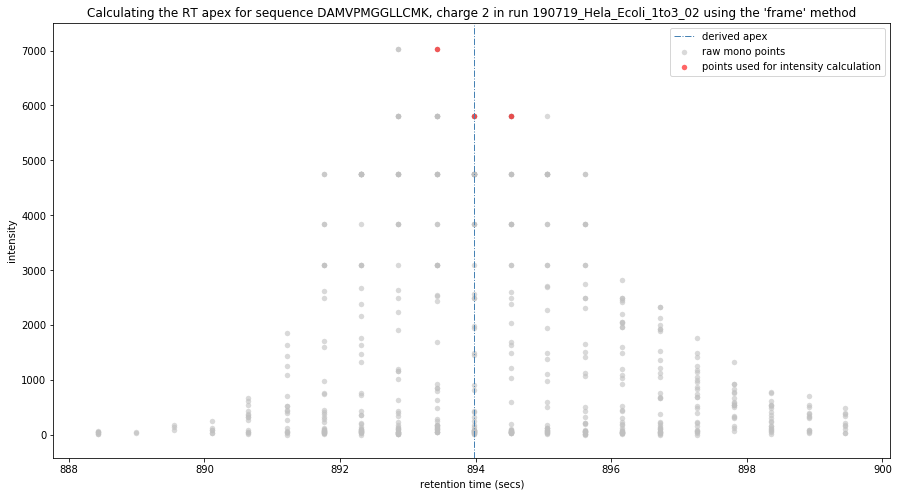

In [84]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Calculating the RT apex for sequence {}, charge {} in run {} using the \'frame\' method'.format(selected_sequence, selected_sequence_charge, run_name)
plt.title(title)

ax.scatter(isotope_df.retention_time_secs, isotope_df.intensity, marker='o', color='silver', lw=0, s=30, alpha=0.6, label='raw mono points')
ax.scatter(isotope_apex_df.retention_time_secs, isotope_apex_df.intensity, marker='o', color='red', lw=0, s=30, alpha=0.6, label='points used for intensity calculation')

ax.axvline(mono_rt_apex_derived, color='steelblue', lw=1.0, ls='-.', label='derived apex')
# ax.axvline(mono_rt_apex_estimated, color='limegreen', lw=1.0, ls='-.', label='estimated apex')

plt.legend(loc='best')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')

plt.show()

#### calculate intensity for this monoisotope using the 'filtered apex' method

In [86]:
# find the intensity by summing the maximum point in the frame closest to the RT apex, and the frame maximums either side
mono_filtered_points_df = pd.DataFrame(json.loads(selected_sequence_s.mono_filtered_points_l))
mono_filtered_points_df

,x,filtered_intensity
0,874.685897,157.216783
1,875.229699,272.755245
2,875.777684,327.417249
3,876.328663,334.565268
4,876.902281,307.561772
...,...,...
61,910.476054,174.403263
62,911.043915,257.322844
63,911.583605,376.801865
64,912.162244,534.958042


In [89]:
# find the index closest to the RT apex and the index either side
if (mono_rt_apex_derived is not None):
    mono_filtered_points_df['rt_delta'] = np.abs(mono_filtered_points_df.x - mono_rt_apex_derived)
    apex_idx = mono_filtered_points_df.rt_delta.idxmin()
else:
    apex_idx = mono_filtered_points_df.filtered_intensity.idxmax()
apex_idx_minus_one = max(0, apex_idx-1)
apex_idx_plus_one = min(len(mono_filtered_points_df)-1, apex_idx+1)
# sum the maximum intensity and the max intensity of the frame either side in RT
summed_intensity = mono_filtered_points_df.loc[apex_idx_minus_one:apex_idx_plus_one].filtered_intensity.sum()
summed_intensity

263400.888111889

In [91]:
isotope_apex_df = mono_filtered_points_df.loc[apex_idx_minus_one:apex_idx_plus_one]

In [92]:
isotope_apex_df

,x,filtered_intensity,rt_delta
30,893.426898,90262.130536,0.541963
31,893.968861,90966.776224,0.000000
32,894.517743,82171.981352,0.548881


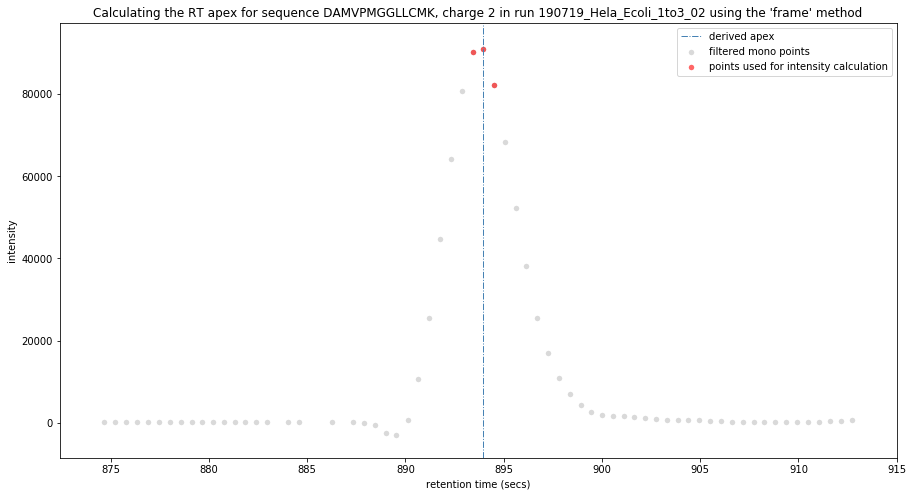

In [95]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Calculating the RT apex for sequence {}, charge {} in run {} using the \'frame\' method'.format(selected_sequence, selected_sequence_charge, run_name)
plt.title(title)

ax.scatter(mono_filtered_points_df.x, mono_filtered_points_df.filtered_intensity, marker='o', color='silver', lw=0, s=30, alpha=0.6, label='filtered mono points')
ax.scatter(isotope_apex_df.x, isotope_apex_df.filtered_intensity, marker='o', color='red', lw=0, s=30, alpha=0.6, label='points used for intensity calculation')

ax.axvline(mono_rt_apex_derived, color='steelblue', lw=1.0, ls='-.', label='derived apex')
# ax.axvline(mono_rt_apex_estimated, color='limegreen', lw=1.0, ls='-.', label='estimated apex')

plt.legend(loc='best')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')

plt.show()